In [108]:
import azureml.core
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from scipy.spatial import distance as sci_distance
from sklearn import cluster as sk_cluster
from azureml.core import Workspace
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from docx import Document
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import itertools
import requests
import time
from sklearn.cluster import KMeans
import re
from sklearn.decomposition import PCA

In [245]:
ws = Workspace.from_config()
#print(ws)

In [5]:
import json
f = open('corpus_data_new2.json','rb') 
corpusdata = json.load(f) 
corpus=[]
filenames=[]
for i in corpusdata:
    corpus.append(corpusdata[i])
    filenames.append(i)

In [21]:
def clean_text(text):
    '''
    Removes default bad characters
    '''
#     if not (pd.isnull(text)):
    # text = filter(lambda x: x in string.printable, text)
    bad_chars = set(["@", "+", '/', "'", '"','(',')', '', '?', '#', ',', '[',']', '%', '$', '&', '!',"*", "_", "=", "}", "{"])
    for char in bad_chars:
        text = text.replace(char, "")
    text = re.sub('\d+', "", text)
    text = re.sub(" +", " ", text)
    return text

In [22]:
def stop_and_stem(text, stem=False, stemmer = PorterStemmer()):
    '''
    Removes stopwords and does stemming
    '''
    stoplist = stopwords.words('english')
    if stem:
        text_stemmed = [stemmer.stem(word) for word in word_tokenize(text) if word not in stoplist and len(word) > 3]
    else:
        text_stemmed = [word for word in word_tokenize(text) if word not in stoplist and len(word) > 3]
    text = ' '.join(text_stemmed)
    return text

In [29]:
#len(corpus)
cleaned_corpus=[]
#text = clean_text(text_test1)
for i in corpus:
    text = clean_text(i)
    cleaned_corpus.append(stop_and_stem(text).encode('ascii','ignore').decode('unicode_escape'))

In [31]:
#creating tagged corpus
tagged_cr = []
for idx, doc in enumerate(cleaned_corpus):
    tagged_cr.append(TaggedDocument(words=doc.split(), tags=[idx]))

In [174]:
#model prep    
d2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1, epochs=80, alpha=0.025)
d2vec_model.build_vocab(tagged_cr)
d2vec_model.train(tagged_cr, total_examples=d2vec_model.corpus_count, epochs=d2vec_model.epochs)

WARNING - consider setting layer size to a multiple of 4 for greater performance


In [224]:
XXX=d2vec_model.docvecs.vectors_docs
np.shape(XXX)


(38, 50)

In [235]:
inferredvector=d2vec_model.infer_vector(cleaned_corpus)
np.shape(np.matrix(inferredvector).A)


(1, 50)

In [225]:
kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=100) 


In [226]:
X = kmeans_model.fit(d2vec_model.docvecs.vectors_docs)


In [227]:
labels=kmeans_model.labels_.tolist()


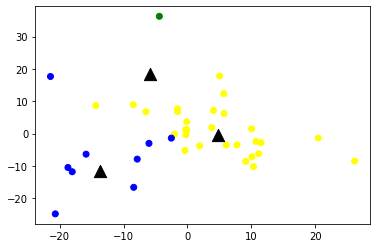

In [228]:
l = kmeans_model.fit_predict(d2vec_model.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(d2vec_model.docvecs.vectors_docs)
datapoint = pca.transform(d2vec_model.docvecs.vectors_docs)
%matplotlib inline
plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [236]:
kmeans_model.predict(np.matrix(inferredvector).A)

array([2], dtype=int32)

In [147]:
from azureml.core import Experiment
experiment_name = 'ClusteringResumes'
experiment = Experiment(workspace = ws, name = experiment_name)

In [184]:
os.mkdir('output')

In [187]:
import joblib
joblib.dump(value=d2vec_model, filename='output/doc2vecgensim.pkl')
joblib.dump(value=kmeans_model, filename='output/kmeans.pkl')

['output/kmeans.pkl']

### Registering Model

In [188]:
from azureml.core.model import Model

doc2vecmodel = Model.register(workspace=ws,model_name='doc2vecgensim.pkl', model_path='output/doc2vecgensim.pkl')
kmeansmodel = Model.register(workspace=ws,model_name='kmeansmodel.pkl', model_path='output/kmeans.pkl')

Registering model doc2vecgensim.pkl
Registering model kmeansmodel.pkl


### Scoring Script

In [237]:
%%writefile score_clustering.py

import json
import numpy as np
from azureml.core.model import Model
import pandas as pd
import joblib
from sklearn.cluster import KMeans
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import itertools
import azureml.core
import re

def init():
    global model
    doc2vecmodel_path = Model.get_model_path(model_name='doc2vecgensim.pkl')
    doc2vecmodel = joblib.load(doc2vecmodel_path)
    kmeansmodel_path = Model.get_model_path(model_name='kmeansmodel.pkl')
    kmeansmodel = joblib.load(kmeansmodel_path)  
def clean_text(text):
    '''
    Removes default bad characters
    '''
    bad_chars = set(["@", "+", '/', "'", '"','(',')', '', '?', '#', ',', '[',']', '%', '$', '&', '!',"*", "_", "=", "}", "{"])
    for char in bad_chars:
        text = text.replace(char, "")
    text = re.sub('\d+', "", text)
    text = re.sub(" +", " ", text)
    return text

def stop_and_stem(text, stem=False, stemmer = PorterStemmer()):
    '''
    Removes stopwords and does stemming
    '''
    stoplist = stopwords.words('english')
    if stem:
        text_stemmed = [stemmer.stem(word) for word in word_tokenize(text) if word not in stoplist and len(word) > 3]
    else:
        text_stemmed = [word for word in word_tokenize(text) if word not in stoplist and len(word) > 3]
    text = ' '.join(text_stemmed)
    return text

def run(raw_data):
    try:
        text=[]
        data = json.loads(raw_data)['data']
        text.append(stop_and_stem(clean_text(data)))
        inferredvector=doc2vecmodel.infer_vector(text)
        result=kmeansmodel.predict(np.matrix(inferredvector).A)
        return result.tolist()
    except Exception as e:
        result = str(e)
        return result


Writing score_clustering.py


In [239]:
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.environment import Environment
from azureml.core.model import InferenceConfig

env = Environment('deploytocloud')
env.python.conda_dependencies = CondaDependencies.create(conda_packages=['scikit-learn'],pip_packages=['azureml-defaults','gensim','joblib','nltk'])
inference_config = InferenceConfig(entry_script="score_clustering.py", environment=env)

In [238]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'sample name': 'clustering'}, 
                                               description='This is a great example.')



In [240]:
%%time
from azureml.core.model import Model
from azureml.core.webservice import Webservice

# Create the webservice using all of the precreated configurations and our best model
service = Model.deploy(workspace=ws,
                       name='clustering-resume',
                       models=[doc2vecmodel,kmeansmodel],
                       inference_config=inference_config,
                       deployment_config=aciconfig)

# Wait for the service deployment to complete while displaying log output
service.wait_for_deployment(show_output=True)

Running..........................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
CPU times: user 8.2 s, sys: 4.24 s, total: 12.4 s
Wall time: 7min 50s


### Handling large files and using external compute

In [242]:
blob_datastore_name='ExtractedResume' # Name of the datastore to workspace
container_name=os.getenv("BLOB_CONTAINER", "") # Name of Azure blob container
account_name=os.getenv("BLOB_ACCOUNTNAME", "") # Storage account name
account_key=os.getenv("BLOB_ACCOUNT_KEY", "") # Storage account key

blob_datastore = Datastore.register_azure_blob_container(workspace=ws, 
                                                         datastore_name=blob_datastore_name, 
                                                         container_name=container_name, 
                                                         account_name=account_name,
                                                         account_key=account_key)

In [ ]:
datastore = Datastore.get(ws, blob_datastore_name)
datastore_paths = [(datastore, 'ExtractedResume')] ### name of the folder which contains extracted resume
resumes = Dataset.File.from_files(path=datastore_paths)


In [ ]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "cpucluster"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

In [ ]:
#### Create a train script, train.py; make a directory "clusteringresume" and copy the train script to this directory

In [ ]:
from azureml.train.estimator import Estimator

#script_params = {
    # to mount files referenced by mnist dataset
    #'--data-folder':dfpath.as_named_input('creditcard').as_mount()
    #'--regularization': 0.8
#}

sk_est = Estimator(source_directory='./clusteringresume',
                   #script_params=script_params,
                   inputs=[resumes.as_named_input('extractedresume')],
                   compute_target=cpu_cluster_name,
                   entry_script='train.py',
                   conda_packages=['scikit-learn'], pip_packages=['joblib','nltk','gensim'])

In [ ]:
run = experiment.submit(sk_est)
print(run.get_portal_url())

In [ ]:
run.wait_for_completion(show_output = True)

In [ ]:
run.get_details()
run.get_file_names()

In [ ]:
os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    if f.startswith(' '):## fill in the name of the model file as mentioned in trainings script
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

In [243]:
##### Continue with the same script from "Registering Model"